In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import sys
import os
import re
import platform
import itertools
from collections import Counter

import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

In [3]:
user_vimms = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "peak_picking", "vimms")
#user_vimms = "vimms"
sys.path.append(user_vimms)

In [4]:
mzmine_path = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "peak_picking", "MZmine-2.53-Windows", "startMZmine-Windows.bat")
#mzmine_path = os.path.join("MZmine-2.53-Windows", "startMZmine-Windows.bat")
old_mzmine = False
template_suffix = "_old" if old_mzmine else ""
mzmine_template = os.path.join(user_vimms, "batch_files", f"multi_sample_peak_pick{template_suffix}.xml")

xcms_r_script = os.path.join(user_vimms, "vimms", "scripts", "xcms_script.R")

In [5]:
from vimms.Common import (
    POSITIVE, load_obj,
    set_log_level_warning,
)
from vimms.PeakPicking import MZMineParams, XCMSScriptParams
from vimms.Experiment import Experiment
from vimms.BoxVisualise import (
    mpl_set_axis_style, mpl_set_figure_style,
    mpl_results_plot, plotly_results_plot,
    mpl_fragmentation_counts,
    plotly_timing_hist, seaborn_timing_hist,
    mpl_fragmentation_events, plotly_fragmentation_events,
    mpl_fragmented_boxes,
    seaborn_uncovered_area_hist,
    BoxViewer
)

 C:\Users\mcbrider5002\anaconda3\lib\site-packages\psims\mzmlb\writer.py:33: UserWarning:hdf5plugin is missing! Only the slower GZIP compression scheme will be available! Please install hdf5plugin to be able to use Blosc.


In [6]:
ionisation_mode = POSITIVE
pbar = False
set_log_level_warning()

1

In [7]:
def match_files(data_dir, regex):
    pattern = re.compile(regex)
    files = (
        (int(pattern.match(fname).group(1)), fname)
        for fname in os.listdir(data_dir)
        if not pattern.match(fname) is None
    )

    return [
        os.path.join(data_dir, fname) 
        for _, fname in sorted(files, key=lambda p: p[0])
    ]

In [8]:
data_dir = os.path.join("C:\\", "Users", "mcbrider5002", "Desktop", "Workspace", "phd", "data", "CLMS", "new_matching_seeds", "Negative")

all_fullscans = match_files(data_dir, r"Vinny_Beers_[0-9]_[0-9]+_ID([0-9]+).mzML")
same_beer_fullscans = all_fullscans[:12]
rep_diff_beer_fullscans = all_fullscans[12:]
id_offset = len(same_beer_fullscans)

In [9]:
num_workers = 8 #can't always use number of physical cores because of memory constraints

Utilities

In [10]:
def load_pkls(pickle_dir, case_names, repeat, load_rois=False):
    exp_pkls = {}
    for case_name in case_names:
        roi_str = "_rois" if load_rois else ""
        exp_pickle_paths = [f"{os.path.join(pickle_dir, case_name)}_{i}{roi_str}.pkl" for i in range(repeat)]
        exp_pkls[case_name] = [load_obj(pkl) for pkl in exp_pickle_paths]
    return exp_pkls

Specify line styles for mpl plots

In [11]:
mpl_colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour_iterator = itertools.cycle(mpl_colours)
colour_map = { # have to do this manually...
    "topN" : mpl_colours[7],
    "topN_exclusion" : mpl_colours[1],
    "dsda" : mpl_colours[2],
    "intensity_non_overlap_smartroi" : mpl_colours[3],
    "unweighted_matching" : mpl_colours[5],
    "two_step_matching" : mpl_colours[0],
    "two_step_matching_with_recursive_assignment" : mpl_colours[6],
    "two_step_matching_with_nearest_assignment" : mpl_colours[8],
    "topNEx_inclusion" : mpl_colours[1],
    "intensity_non_overlap_smartroi_inclusion" : mpl_colours[3]
}

def update_cmap(name):
    if(not name in colour_map):
        colour_map[name] = next(colour_iterator)
    return colour_map[name]

def get_style(name):
    if(name.lower().endswith("inclusion")):
        marker = "v"
    elif("matching" in name):
        marker = "^"
    else:
        marker = "o"
    
    c = update_cmap(name)
    return c, marker
    
def get_line_styles(case_names):
    colours, markers = [], []
    for case_name in case_names:
        c, m = get_style(case_name)
        colours.append(c)
        markers.append(m)
    return colours, markers

In [12]:
dda_name_map = {
    "topN" : "TopN",
    "topN_RoI" : "TopN RoI",
    "topN_exclusion" : "TopN Exclusion",
    "topNEx" : "TopNEX",
    "hard_roi_exclusion" : "Hard RoI Exclusion",
    "intensity_roi_exclusion" : "Intensity RoI Exclusion",
    "non_overlap" : "Non-Overlap",
    "intensity_non_overlap" : "INO"
}

matching_name_map = {
    "unweighted_matching" : "Unweighted Matching",
    "two_step_matching" : "TS Matching",
    "two_step_matching_with_recursive_assignment" : "TS Matching - R",
    "two_step_matching_with_nearest_assignment" : "TS Matching - N",
}

#make smartroi/weighteddew versions of DDA
expanded_dda_name_map = {
    **dda_name_map,
    **{name + "_smartroi" : fname for name, fname in dda_name_map.items()},
    **{name + "_weighteddew" : fname for name, fname in dda_name_map.items()}
}

#make inclusion versions of all DDA incl. smartroi/weighteddew
inclusion_dda_name_map = {
    name + "_inclusion" : fname + " +" for name, fname in expanded_dda_name_map.items()
}

name_map = {
    "dsda" : "DsDA",
    **expanded_dda_name_map,
    **inclusion_dda_name_map,
    **matching_name_map
}

markersize = 10

shared_legend = [
    Line2D([0], [0], marker="o", color="black", label="Baseline", markerfacecolor="black", markersize=markersize),
    Line2D([0], [0], marker="^", color="black", label="Matching", markerfacecolor="black", markersize=markersize),
    Line2D([0], [0], marker="v", color="black", label="Inclusion Windows", markerfacecolor="black", markersize=markersize),
]

def get_legend_items(case_names):
    case_legend = []
    for name in case_names:
        c, m = get_style(name)
        case_legend.append(
            Line2D([0], [0], marker=m, color=c, label=name_map[name], markersize=markersize)
        )

    return case_legend

In [13]:
fig_kwargs = {
    "tick_kwargs" : {
        "width" : 2.5,
        "length" : 12,
        "labelsize" : 22,
    },
    
    "axis_borderwidth" : 2.5,
    
    "axis_kwargs" : {
        "labelsize" : 24,
        "titlesize" : 24,
        "linewidth" : 1.5,
        "markersize" : 8
    },
    
    "suptitle" : "Default Suptitle",
    "suptitle_size" : 26,
    "figure_sizes" : (18, 18),
}

In [14]:
centwave_params = {
    "ppm" : 15,
    "pwlower" : 15,
    "pwupper" : 80,
    "snthresh" : 5,
    "noise" : 1000,
    "prefilterlower" : 3,
    "prefilterupper" : 500,
    "mzdiff" : 0.001
}

mzmine_object = MZMineParams(
    mzmine_template = mzmine_template,
    mzmine_exe = mzmine_path
)

xcms_object = XCMSScriptParams(
    xcms_r_script = xcms_r_script,
    **centwave_params,
    mzvsrtbalance = None,
    absmz = None,
    absrt = None,
    kNN = None
)

#pp_params = mzmine_object
pp_params = xcms_object

param_suffix = (
    ("_permissive" if old_mzmine else "_restrictive")
    if pp_params.method_name.lower() == "mzmine"
    else ""
)

In [15]:
def get_exhaustive_metrics(exp_name, exh_exps):    
        last_eva = exh_exps[-1].get_evaluator_by_name(exp_name) 
        last_report = last_eva.evaluation_report(min_intensity=5000.0)

        num_appears = last_report["num_appears"]
        chem_appears = last_report["chem_appears"]
        max_coverage_intensities = np.amax(last_report["max_possible_intensity"], axis=0)
        max_appears = max_coverage_intensities[chem_appears]
        
        coverage, it_coverage = [], []
        for iter_exp in exh_exps:
            eva = iter_exp.get_evaluator_by_name(exp_name)
            report = eva.evaluation_report(min_intensity=5000.0)

            # Re-calc proportion to include injections we haven't done in this experiment
            coverage.append(report["sum_cumulative_coverage"][-1] / num_appears)
            it_coverage.append(
                np.mean(np.array(report["cumulative_intensity"])[-1, chem_appears] / max_appears)
            )

        return coverage, it_coverage

In [16]:
def get_box_file(reader, in_dir, basename):
    aligned_file = reader.format_output_path(in_dir, basename)
    return aligned_file, reader.read_aligned_csv(aligned_file)

def compare_files(reader, in_dir, basename, compare_sets=None):
    fname, (fs_names, rows) = get_box_file(reader, in_dir, basename)
    rows = list(rows)
    
    present = []
    for row_dict, mzml_dict in rows:
        row_present = [mzml_dict[name]["status"] == "DETECTED" for name in fs_names]
        present.append(row_present)

    if(not compare_sets is None):
        counts = []
        for row_dict, mzml_dict in rows:
            counts.append(
                [
                    any(mzml_dict[name]["status"] == "DETECTED" for name in fs_ls)
                    for fs_ls in compare_sets
                ]
            )
        compare_counts = [sum(counts[j][i] for j, _ in enumerate(counts)) for i, _ in enumerate(compare_sets)]
        compare_shared_counts = Counter(sum(row) for row in counts)
    else:
        compare_counts = None
        compare_shared_counts = None

    return {
        "fname": fname,
        "counts": [sum(present[j][i] for j, _ in enumerate(present)) for i, _ in enumerate(fs_names)],
        "shared_counts": Counter(sum(row) for row in present),
        "compare_counts": compare_counts,
        "compare_shared_counts": compare_shared_counts
    }

def print_report(report):
    total_boxes = sum(v for _, v in report['shared_counts'].items())
    
    print(report["fname"])
    print(f"Individual Counts: {report['counts']}")
    print(f"Shared Counts: {report['shared_counts']}")
    print(f"Maximum Coverage Proportion Against Whole: {[float(c) / total_boxes for c in report['counts']]}")

    if(len(report['counts']) == 2):
        print(f"Maximum Coverage Proportion Against Other: {[report['shared_counts'][2] / c for c in report['counts']]}")
    
    if(not report["compare_shared_counts"] is None):
        print(f"Shared Counts Between Chosen Sets: {report['compare_shared_counts']}")
        if(max(report["compare_shared_counts"].keys()) == 2):
            print(f"Maximum Coverage Proportion Between Chosen Sets (Approx): {[report['compare_shared_counts'][2] / c for c in report['compare_counts']]}")
    
    print(f"Total: {total_boxes}")
    print()

In [17]:
class ResultsPlot():

    matching_display_names = ["unweighted_matching", "two_step_matching", "topNEx_inclusion", "intensity_non_overlap_smartroi_inclusion"]
    
    def __init__(self, all_names, matching_names, min_intensity):
        self.fig, self.axes = plt.subplots(2, 2)
        self.all_names, self.matching_names = all_names, matching_names
        self.other_names = [name for name in all_names if not name in self.matching_names]
        self.min_intensity = min_intensity
        
        self.overlap_percentage = None

    def count_peak_overlap(self, pp_params, in_dir, aligned_name, compare_sets):
        report = compare_files(pp_params, in_dir, aligned_name, compare_sets=compare_sets)
        self.overlap_percentage = report["compare_shared_counts"][2] / report['compare_counts'][1]

    def get_legend_kwargs(self, exhaustive=False):
        legend_names = []
        for name in self.all_names:
            if(name in self.other_names or name in self.matching_display_names or not exhaustive):
                legend_names.append(name)

        return {
            "fontsize" : 14,
            "facecolor" : (1, 1, 1, 0.2),
            "framealpha" : 0.5,
            "ncol" : 2,
            "loc" : "lower right",
            "handles" : get_legend_items(legend_names),
            "alignment" : "right"
        }

    def add_lines(self, iter_exp_list):
        final_exp = iter_exp_list[-1]
        
        for case_name in self.all_names:
            report = final_exp.get_evaluator_by_name(case_name).evaluation_report(min_intensity=self.min_intensity)
            coverage = report["cumulative_coverage_proportion"]
            it_coverage = report["cumulative_intensity_proportion"]
            
            xs = list(range(1, len(coverage) + 1))
            c, m = style_dict[case_name]
            self.axes[0][0].plot(xs, coverage, label=case_name, color=c, marker=m)
            self.axes[0][0].legend(**self.get_legend_kwargs())
            self.axes[0][1].plot(xs, it_coverage, label=case_name, color=c, marker=m)
            self.axes[0][1].legend(**self.get_legend_kwargs())

            if(case_name in self.matching_names):
                coverage, it_coverage = get_exhaustive_metrics(case_name, iter_exp_list)
                if(not case_name in self.matching_display_names):
                    continue
            else:
                report = final_exp.get_evaluator_by_name(case_name).evaluation_report(min_intensity=self.min_intensity)
                coverage = report["cumulative_coverage_proportion"]
                it_coverage = report["cumulative_intensity_proportion"]
            
            xs = list(range(1, len(coverage) + 1))
            c, m = style_dict[case_name]
            self.axes[1][0].plot(xs, coverage, label=case_name, color=c, marker=m)
            self.axes[1][0].legend(**self.get_legend_kwargs(exhaustive=True))
            self.axes[1][1].plot(xs, it_coverage, label=case_name, color=c, marker=m)
            self.axes[1][1].legend(**self.get_legend_kwargs(exhaustive=True))

            for i in range(2):
                self.axes[i][0].set(ylabel="Cumulative Coverage Proportion")
                self.axes[i][1].set(ylabel="Cumulative Intensity Proportion")
                self.axes[1][i].set(xlabel="Num. Runs")
    
    def add_iterswaplines(self, iter_exp_list, iterswap_exp_list):
        final_exp = iter_exp_list[-1]

        if(not self.overlap_percentage is None):
            for i in range(2):
                self.axes[i][0].plot([1, len(iter_exp_list)], [self.overlap_percentage, self.overlap_percentage], c="black", linestyle="--", marker=None)

        for case_name in self.all_names:
            if(case_name in self.matching_names):
                report = iterswap_exp_list[-1].get_evaluator_by_name(case_name).evaluation_report(min_intensity=self.min_intensity)
                coverage = report["cumulative_coverage_proportion"]
                it_coverage = report["cumulative_intensity_proportion"]
            else:
                report = final_exp.get_evaluator_by_name(case_name).evaluation_report(min_intensity=self.min_intensity)
                coverage = report["cumulative_coverage_proportion"]
                it_coverage = report["cumulative_intensity_proportion"]
            
            xs = list(range(1, len(coverage) + 1))
            c, m = style_dict[case_name]
            self.axes[0][0].plot(xs, coverage, label=case_name, color=c, marker=m)
            self.axes[0][0].legend(**self.get_legend_kwargs())
            self.axes[0][1].plot(xs, it_coverage, label=case_name, color=c, marker=m)
            self.axes[0][1].legend(**self.get_legend_kwargs())

            if(case_name in self.matching_names):
                coverage, it_coverage = get_exhaustive_metrics(case_name, iterswap_exp_list)
                #if(not case_name in self.matching_display_names):
                #    continue
            else:
                report = final_exp.get_evaluator_by_name(case_name).evaluation_report(min_intensity=self.min_intensity)
                coverage = report["cumulative_coverage_proportion"]
                it_coverage = report["cumulative_intensity_proportion"]
            
            xs = list(range(1, len(coverage) + 1))
            c, m = style_dict[case_name]
            self.axes[1][0].plot(xs, coverage, label=case_name, color=c, marker=m)
            self.axes[1][0].legend(**self.get_legend_kwargs(exhaustive=False))
            self.axes[1][1].plot(xs, it_coverage, label=case_name, color=c, marker=m)
            self.axes[1][1].legend(**self.get_legend_kwargs(exhaustive=False))

            for i in range(2):
                self.axes[i][0].set(ylabel="Cumulative Coverage Proportion")
                self.axes[i][1].set(ylabel="Cumulative Intensity Proportion")
                self.axes[1][i].set(xlabel="Num. Runs")
    
    def output_figure(self, out_name, fig_kwargs=None, xticks=None):
        mpl_set_figure_style(self.fig, **fig_kwargs)
        self.fig.legend(fontsize = 18, handles=shared_legend, loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=3)
        plt.gcf().text(0.07, 0.9, "A", fontsize=40)
        plt.gcf().text(0.07, 0.47, "B", fontsize=40)

        for row in self.axes:
            for ax in row:
                ax.set(xticks=xticks)

            yticks = ax.get_yticks()
            new_yticks = sorted(set(int(y * 10) / 10 for y in yticks)) #Floor to 1 dec. pl.
            ax.set(yticks=new_yticks)
        
        os.makedirs(os.path.join("paper", "plots"), exist_ok=True)
        self.fig.savefig(os.path.join("paper", "plots", out_name), format="pdf", bbox_inches="tight")

# 1. Same Beer Repeated Multiple Times (Same Fullscans)

### Evaluate

In [18]:
repeat = 6
beer_dir = "same_beer"

same_case_names = [
    "topN",
    #"topN_RoI",
    "topN_exclusion",
    "dsda",
    #"topNEx",
    #"topNEx_smartroi",
    #"topNEx_weighteddew",
    #"hard_roi_exclusion",
    #"hard_roi_exclusion_smartroi",
    #"hard_roi_exclusion_weighteddew",
    #"intensity_roi_exclusion",
    #"intensity_roi_exclusion_smartroi",
    #"intensity_roi_exclusion_weighteddew",
    #"non_overlap",
    #"non_overlap_smartroi",
    #"non_overlap_weighteddew",
    #"intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    #"intensity_non_overlap_weighteddew",
    "unweighted_matching",
    "two_step_matching",
    "two_step_matching_with_recursive_assignment",
    "two_step_matching_with_nearest_assignment",
    "topNEx_inclusion", 
    "intensity_non_overlap_smartroi_inclusion"
]

line_colours, line_markers = get_line_styles(same_case_names)
legend_elements = get_legend_items(same_case_names)
style_dict = {
    case_name : (c, m) 
    for case_name, c, m in zip(same_case_names, line_colours, line_markers)
} # use to get line styles for a subset

print(style_dict)

matching_case_names = [
    name for name in list(inclusion_dda_name_map.keys()) + list(matching_name_map.keys()) 
    if name in same_case_names
]
other_case_names = [name for name in same_case_names if not name in matching_case_names]

{'topN': ('#7f7f7f', 'o'), 'topN_exclusion': ('#ff7f0e', 'o'), 'dsda': ('#2ca02c', 'o'), 'intensity_non_overlap_smartroi': ('#d62728', 'o'), 'unweighted_matching': ('#8c564b', '^'), 'two_step_matching': ('#1f77b4', '^'), 'two_step_matching_with_recursive_assignment': ('#e377c2', '^'), 'two_step_matching_with_nearest_assignment': ('#bcbd22', '^'), 'topNEx_inclusion': ('#ff7f0e', 'v'), 'intensity_non_overlap_smartroi_inclusion': ('#d62728', 'v')}


In [19]:
isolation_width = 1.0
#isolation_width = None

same_beer_dirs = (beer_dir,)
same_beer_exps = [[] for dir in same_beer_dirs]

for out_dir, exp_list in zip(same_beer_dirs, same_beer_exps):
    for i in range(repeat):
        iter_dir = os.path.join(out_dir, str(i+1))
        
        if(os.path.exists(iter_dir)):
        
            iter_exp = Experiment.load_from_json(
                file_dir = iter_dir,
                file_name = "keyfile.json",
                out_dir = iter_dir,
                fullscan_dir = data_dir,
                amend_result_path = True,
                case_names = None
            )
            
            iter_exp.evaluate(
                pp_params = pp_params,
                num_workers = num_workers,
                isolation_widths = isolation_width,
                max_repeat = repeat,
                aligned_names = f"stefanbeersID{repeat+1}" + template_suffix,
                force_peak_picking = False
            )
            
            exp_list.append(iter_exp)

5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file

5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file

5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file
5784 aligned boxes contained in file

In [20]:
same_beer_exps[0][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

two_step_matching_with_recursive_assignment
Number of chems above min intensity: 4642
Number of fragmentations: [6560, 6560, 6560, 6560, 6560, 6560]
Cumulative coverage: [3045, 3899, 4267, 4416, 4477, 4496]
Cumulative coverage proportion: [0.6559672554933218, 0.8399396811719086, 0.9192158552348125, 0.951314088754847, 0.9644549763033176, 0.968548039638087]
Cumulative intensity proportion: [0.5776841239931058, 0.7699570926760605, 0.8644415106090532, 0.9121022997816711, 0.9373739443995079, 0.9525901181445289]
Cumulative intensity proportion of covered spectra: [0.8806600011743833, 0.9166814116958893, 0.9404118800673131, 0.9587814482759324, 0.9719208956673031, 0.9835238719810727]
Times covered: {0: 1288, 1: 120, 2: 562, 3: 1056, 4: 1016, 5: 737, 6: 1005}
Times fragmented: {0: 1229, 1: 57, 2: 247, 3: 340, 4: 715, 5: 575, 6: 390, 7: 263, 8: 327, 9: 186, 10: 227, 11: 127, 12: 130, 13: 68, 14: 119, 15: 59, 16: 59, 17: 39, 18: 38, 19: 38, 20: 31, 21: 12, 22: 21, 23: 23, 24: 16, 25: 18, 26: 18, 

### Plot

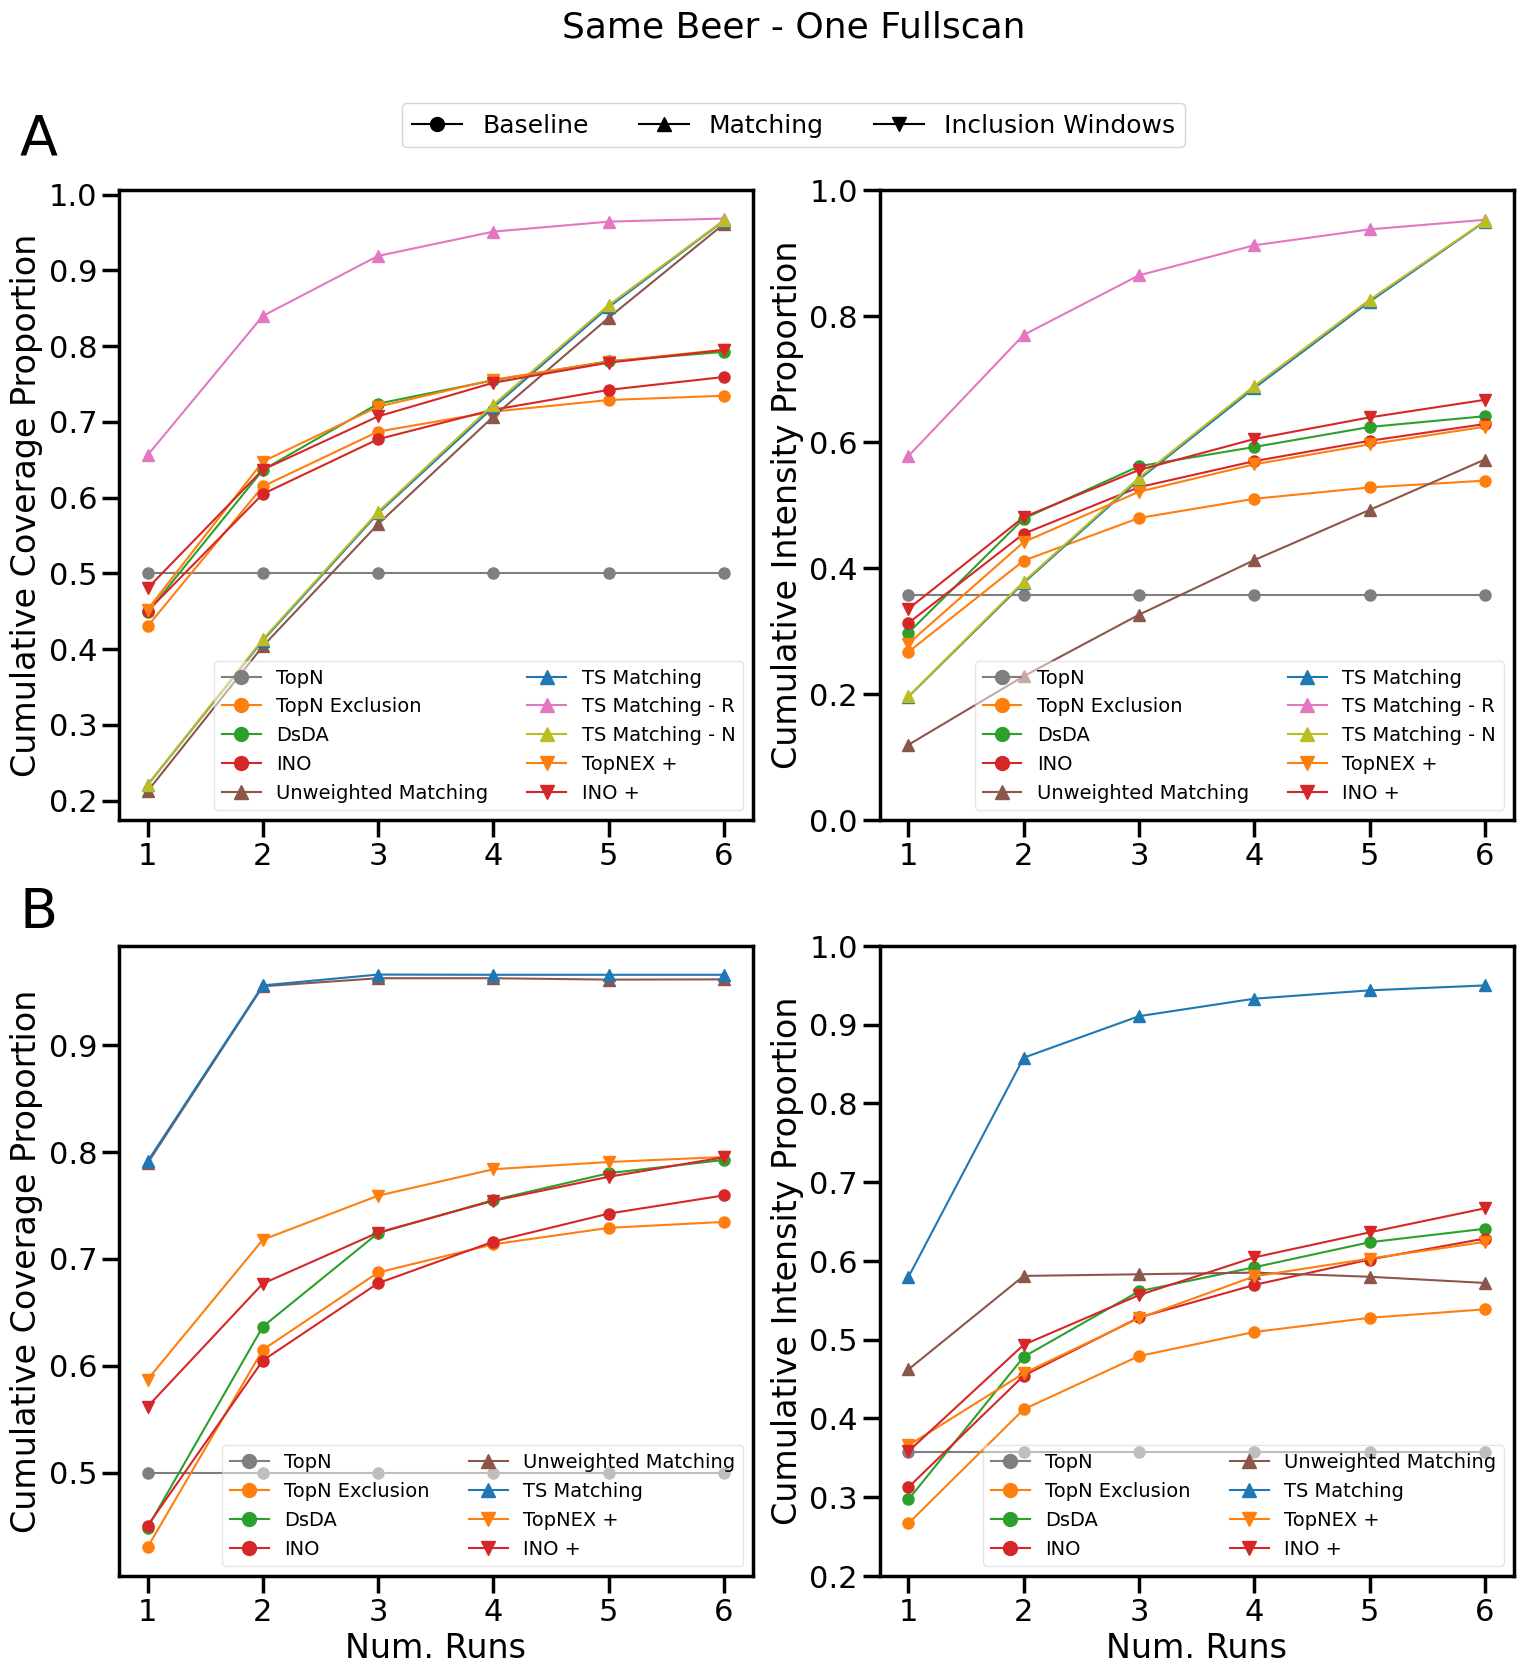

In [21]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Same Beer - One Fullscan"
}

plot_object = ResultsPlot(same_case_names, matching_case_names, 5000.0)
plot_object.add_lines(same_beer_exps[0])
plot_object.output_figure(f"same_beer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(1, 7)))

# 2+3. Same Beer Repeated Multiple Times (Different Fullscans, Same+Different Plan)

### Evaluate

In [22]:
repeat = 6
iterbeer_dir = "same_iterbeer"
iterswapbeer_dir = "same_iterswapbeer"

same_case_names = [
    "topN",
    #"topN_RoI",
    "topN_exclusion",
    "dsda",
    #"topNEx",
    #"topNEx_smartroi",
    #"topNEx_weighteddew",
    #"hard_roi_exclusion",
    #"hard_roi_exclusion_smartroi",
    #"hard_roi_exclusion_weighteddew",
    #"intensity_roi_exclusion",
    #"intensity_roi_exclusion_smartroi",
    #"intensity_roi_exclusion_weighteddew",
    #"non_overlap",
    #"non_overlap_smartroi",
    #"non_overlap_weighteddew",
    #"intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    #"intensity_non_overlap_weighteddew",
    "unweighted_matching",
    "two_step_matching",
    "two_step_matching_with_recursive_assignment",
    "two_step_matching_with_nearest_assignment",
    "topNEx_inclusion", 
    "intensity_non_overlap_smartroi_inclusion"
]

line_colours, line_markers = get_line_styles(same_case_names)
legend_elements = get_legend_items(same_case_names)
style_dict = {
    case_name : (c, m) 
    for case_name, c, m in zip(same_case_names, line_colours, line_markers)
} # use to get line styles for a subset

print(style_dict)

matching_case_names = [
    name for name in list(inclusion_dda_name_map.keys()) + list(matching_name_map.keys()) 
    if name in same_case_names
]
other_case_names = [name for name in same_case_names if not name in matching_case_names]

{'topN': ('#7f7f7f', 'o'), 'topN_exclusion': ('#ff7f0e', 'o'), 'dsda': ('#2ca02c', 'o'), 'intensity_non_overlap_smartroi': ('#d62728', 'o'), 'unweighted_matching': ('#8c564b', '^'), 'two_step_matching': ('#1f77b4', '^'), 'two_step_matching_with_recursive_assignment': ('#e377c2', '^'), 'two_step_matching_with_nearest_assignment': ('#bcbd22', '^'), 'topNEx_inclusion': ('#ff7f0e', 'v'), 'intensity_non_overlap_smartroi_inclusion': ('#d62728', 'v')}


In [23]:
isolation_width = 1.0
#isolation_width = None

same_beer_dirs = (iterbeer_dir, iterswapbeer_dir)
same_beer_exps = [[] for dir in same_beer_dirs]

for out_dir, exp_list in zip(same_beer_dirs, same_beer_exps):
    for i in range(repeat):
        iter_dir = os.path.join(out_dir, str(i+1))
        
        if(os.path.exists(iter_dir)):
        
            iter_exp = Experiment.load_from_json(
                file_dir = iter_dir,
                file_name = "keyfile.json",
                out_dir = iter_dir,
                fullscan_dir = data_dir,
                amend_result_path = True,
                case_names = None
            )
            
            iter_exp.evaluate(
                pp_params = pp_params,
                num_workers = num_workers,
                isolation_widths = isolation_width,
                max_repeat = repeat,
                aligned_names = f"stefanbeersID{repeat+1}-{2*repeat}" + template_suffix,
                force_peak_picking = False
            )
            
            exp_list.append(iter_exp)

9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file

9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file

9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file
9671 aligned boxes contained in file

In [24]:
same_beer_exps[0][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

two_step_matching_with_recursive_assignment
Number of chems above min intensity: 7889
Number of fragmentations: [6560, 6560, 6560, 6560, 6560, 6560]
Cumulative coverage: [2474, 4143, 5388, 6265, 6955, 7526]
Cumulative coverage proportion: [0.31360121688426923, 0.5251616174420078, 0.6829762961085055, 0.7941437444543035, 0.8816073013056154, 0.9539865635695272]
Cumulative intensity proportion: [0.24476761593473859, 0.43092844040745226, 0.5846612550495525, 0.7098281449001731, 0.8161015867378996, 0.9139288452103174]
Cumulative intensity proportion of covered spectra: [0.7805059507312663, 0.820563472453389, 0.8560491167568521, 0.8938282897234581, 0.9256974001114722, 0.9580101860037461]
Times covered: {0: 2145, 1: 3209, 2: 2375, 3: 1235, 4: 503, 5: 169, 6: 35}
Times fragmented: {0: 2068, 1: 400, 2: 896, 3: 1325, 4: 1103, 5: 727, 6: 705, 7: 379, 8: 283, 9: 188, 10: 188, 11: 163, 12: 140, 13: 124, 14: 94, 15: 88, 16: 86, 17: 86, 18: 49, 19: 86, 20: 38, 21: 41, 22: 27, 23: 25, 24: 28, 25: 28, 26

In [25]:
same_beer_exps[1][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

intensity_non_overlap_weighteddew_inclusion
Number of chems above min intensity: 7841
Number of fragmentations: [6558, 6558, 6558, 6558, 6558, 6558]
Cumulative coverage: [2343, 3617, 4377, 4843, 5262, 5599]
Cumulative coverage proportion: [0.29881392679505164, 0.46129320239765337, 0.5582196148450452, 0.617650809845683, 0.6710878714449687, 0.7140670832801939]
Cumulative intensity proportion: [0.18558182149881158, 0.31854796339055574, 0.40425186723354367, 0.4639613658091529, 0.5173090522833869, 0.5625035967102227]
Cumulative intensity proportion of covered spectra: [0.6210614862877429, 0.6905542109331898, 0.7241806924784592, 0.7511709827192996, 0.7708514403181369, 0.7877461514207637]
Times covered: {0: 4072, 1: 2084, 2: 1369, 3: 1041, 4: 623, 5: 351, 6: 131}
Times fragmented: {0: 3739, 1: 1468, 2: 1160, 3: 879, 4: 632, 5: 461, 6: 316, 7: 228, 8: 159, 9: 106, 10: 70, 11: 67, 12: 41, 13: 41, 14: 35, 15: 31, 16: 14, 17: 20, 18: 15, 19: 11, 20: 7, 21: 9, 22: 13, 23: 8, 24: 13, 25: 6, 26: 8, 

### Plot

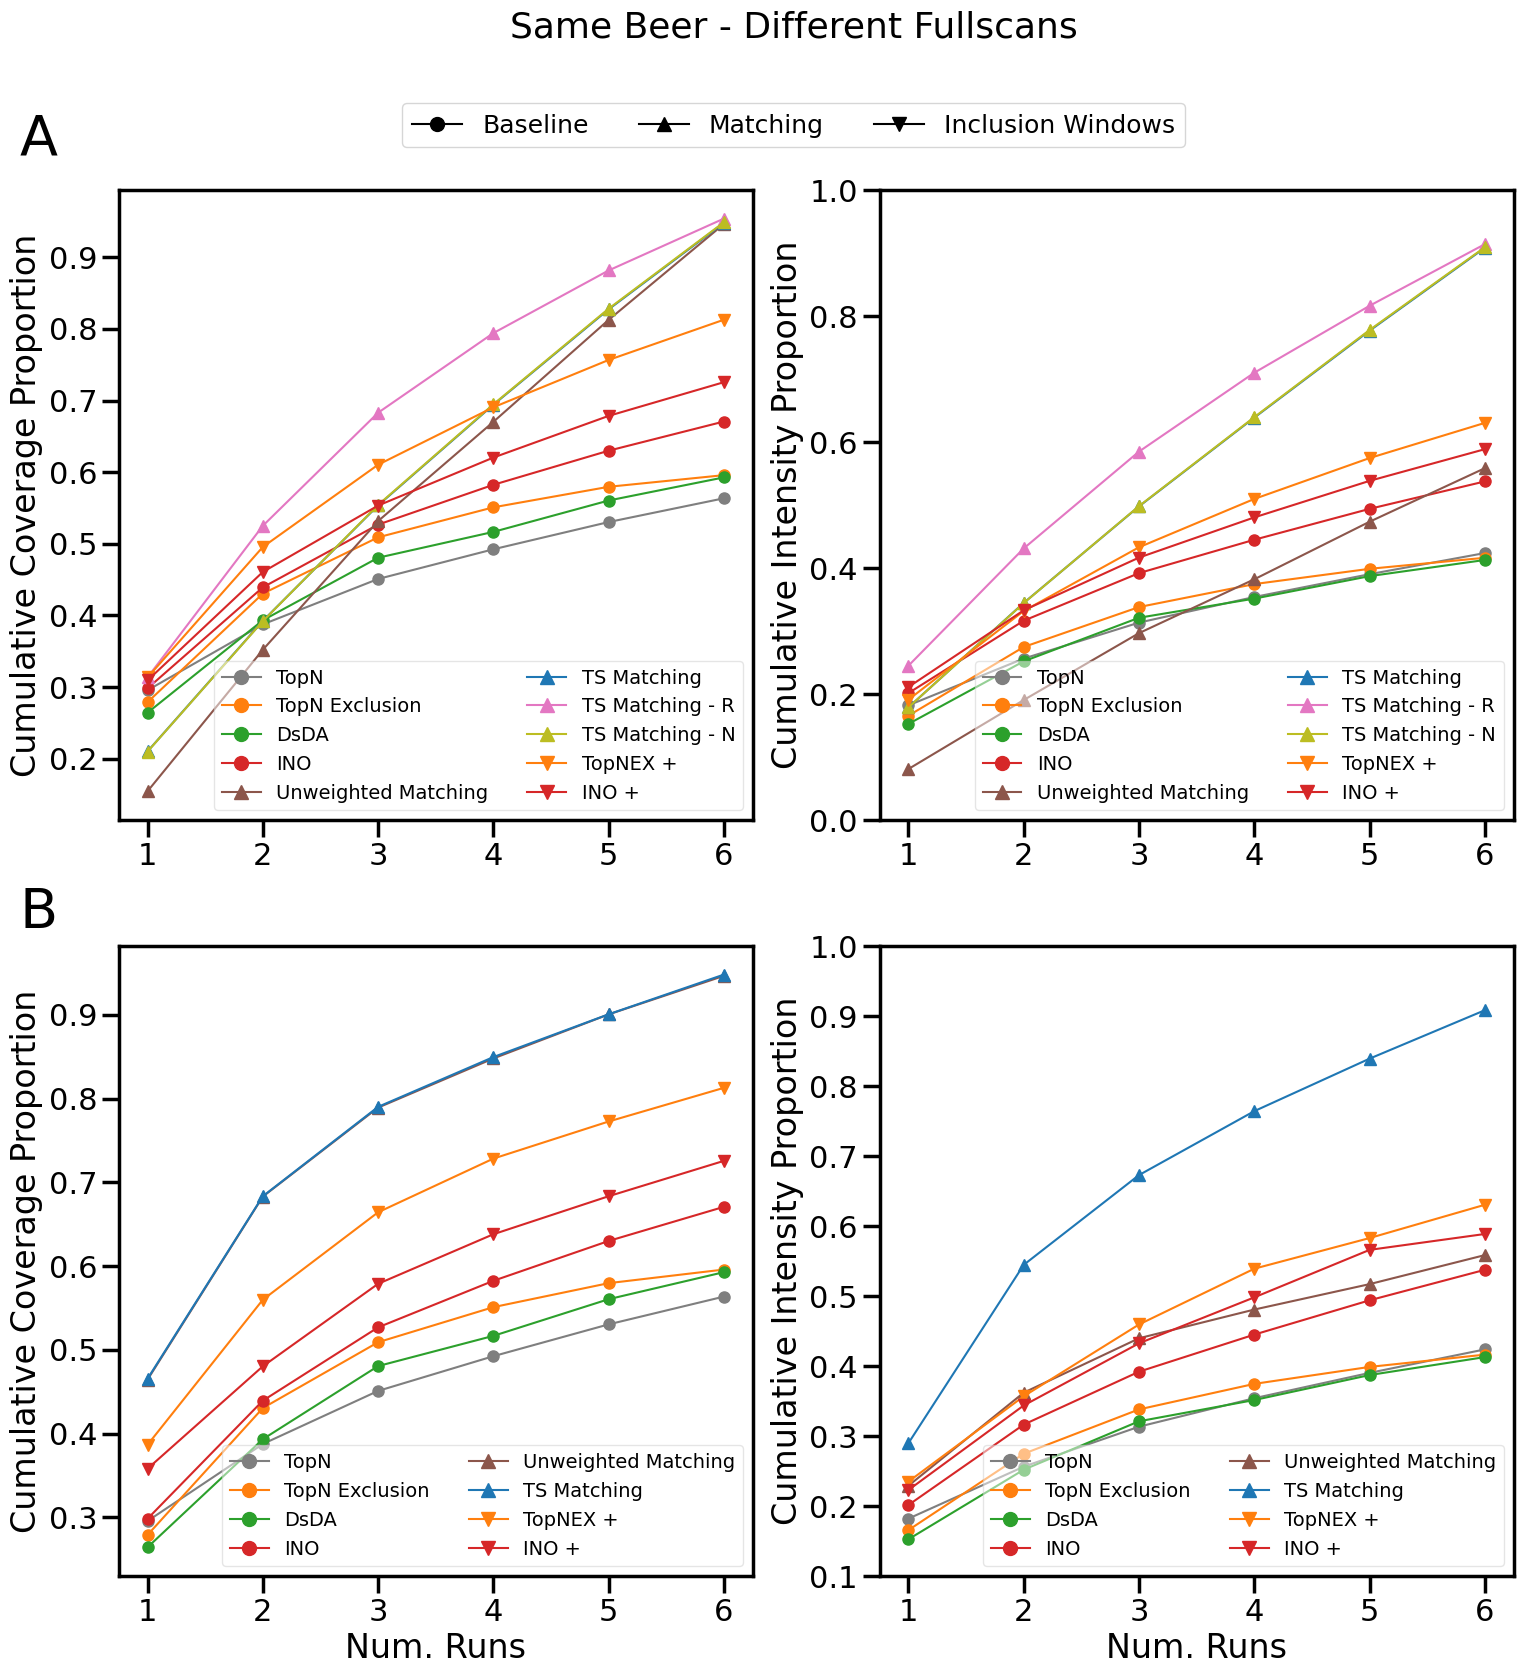

In [26]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Same Beer - Different Fullscans"
}

plot_object = ResultsPlot(same_case_names, matching_case_names, 5000.0)
plot_object.add_lines(same_beer_exps[0])
plot_object.output_figure(f"same_iterbeer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(1, 7)))

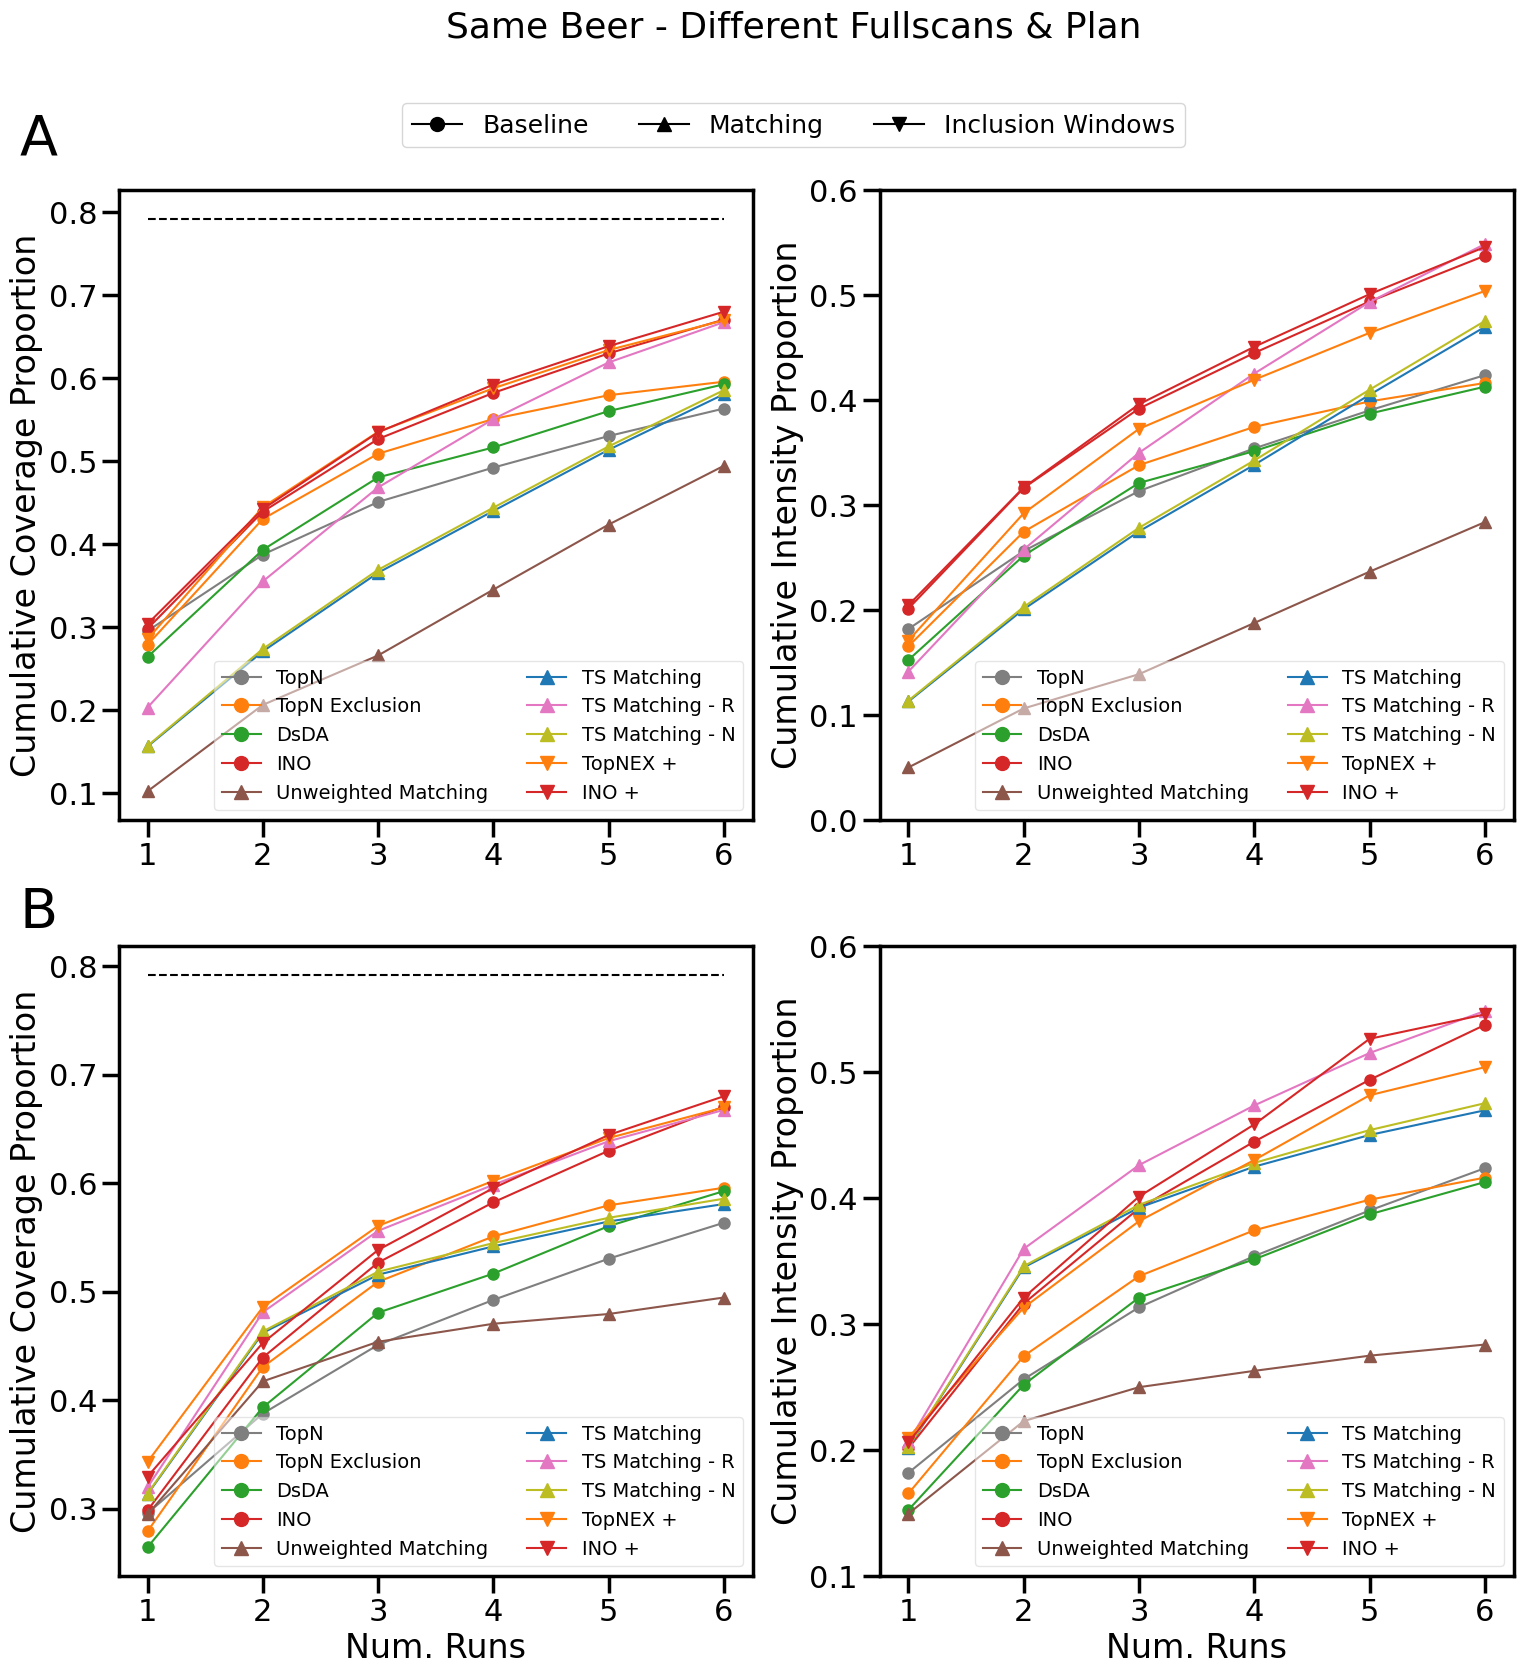

In [27]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Same Beer - Different Fullscans & Plan"
}

plot_object = ResultsPlot(same_case_names, matching_case_names, 5000.0)
#NB: compare sets must be in the order of planning -> real
compare_sets = [
    ["".join(os.path.basename(name).split(".")[:-1]) for name in same_beer_fullscans[:repeat]],
    ["".join(os.path.basename(name).split(".")[:-1]) for name in same_beer_fullscans[repeat:repeat*2]]
]
plot_object.count_peak_overlap(pp_params, "same_iterswapbeer", f"stefanbeersID1-{repeat*2}", compare_sets=compare_sets)
plot_object.add_iterswaplines(same_beer_exps[0], same_beer_exps[1])
plot_object.output_figure(f"same_iterswapbeer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(1, 7)))

# 4. Repeating Different Beers (Same Fullscans)

### Evaluate

In [28]:
bio_repeat = 4
tech_repeat = 3
repeat = bio_repeat * tech_repeat
beer_dir = "repeated_different_beer"

rep_diff_case_names = [
    "topN",
    #"topN_RoI",
    "topN_exclusion",
    "dsda",
    #"topNEx",
    #"topNEx_smartroi",
    #"topNEx_weighteddew",
    #"hard_roi_exclusion",
    #"hard_roi_exclusion_smartroi",
    #"hard_roi_exclusion_weighteddew",
    #"intensity_roi_exclusion",
    #"intensity_roi_exclusion_smartroi",
    #"intensity_roi_exclusion_weighteddew",
    #"non_overlap",
    #"non_overlap_smartroi",
    #"non_overlap_weighteddew",
    #"intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    #"intensity_non_overlap_weighteddew",
    "unweighted_matching",
    "two_step_matching",
    "two_step_matching_with_recursive_assignment",
    "two_step_matching_with_nearest_assignment",
    "topNEx_inclusion", 
    "intensity_non_overlap_smartroi_inclusion"
]

line_colours, line_markers = get_line_styles(rep_diff_case_names)
legend_elements = get_legend_items(rep_diff_case_names)
style_dict = {
    case_name : (c, m) 
    for case_name, c, m in zip(rep_diff_case_names, line_colours, line_markers)
} # use to get line styles for a subset

print(style_dict)

matching_case_names = [
    name for name in list(inclusion_dda_name_map.keys()) + list(matching_name_map.keys()) 
    if name in rep_diff_case_names
]
other_case_names = [name for name in rep_diff_case_names if not name in matching_case_names]

{'topN': ('#7f7f7f', 'o'), 'topN_exclusion': ('#ff7f0e', 'o'), 'dsda': ('#2ca02c', 'o'), 'intensity_non_overlap_smartroi': ('#d62728', 'o'), 'unweighted_matching': ('#8c564b', '^'), 'two_step_matching': ('#1f77b4', '^'), 'two_step_matching_with_recursive_assignment': ('#e377c2', '^'), 'two_step_matching_with_nearest_assignment': ('#bcbd22', '^'), 'topNEx_inclusion': ('#ff7f0e', 'v'), 'intensity_non_overlap_smartroi_inclusion': ('#d62728', 'v')}


In [29]:
isolation_width = 1.0
#isolation_width = None

rep_diff_beer_dirs = (beer_dir,)
rep_diff_beer_exps = [[] for dir in rep_diff_beer_dirs]

for out_dir, exp_list in zip(rep_diff_beer_dirs, rep_diff_beer_exps):
    for i in range(repeat):
        iter_dir = os.path.join(out_dir, str(i+1))
        
        if(os.path.exists(iter_dir)):
        
            iter_exp = Experiment.load_from_json(
                file_dir = iter_dir,
                file_name = "keyfile.json",
                out_dir = iter_dir,
                fullscan_dir = data_dir,
                amend_result_path = True,
                case_names = None
            )
            
            iter_exp.evaluate(
                pp_params = pp_params,
                num_workers = num_workers,
                isolation_widths = isolation_width,
                max_repeat = repeat,
                aligned_names = f"stefanbeersID{id_offset+1}-{id_offset+bio_repeat}" + template_suffix,
                force_peak_picking = False
            )
            
            exp_list.append(iter_exp)

11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file

11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file

11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 aligned boxes contained in file
11804 alig

In [30]:
rep_diff_beer_exps[0][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

two_step_matching_with_recursive_assignment
Number of chems above min intensity: 9761
Number of fragmentations: [6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560]
Cumulative coverage: [2620, 4977, 6909, 8258, 8604, 8895, 9137, 9301, 9349, 9394, 9419, 9437]
Cumulative coverage proportion: [0.26841512140149576, 0.5098862821432231, 0.7078168220469214, 0.8460198750128061, 0.8814670628009426, 0.91127958201004, 0.9360721237578117, 0.9528736809753099, 0.9577912099170167, 0.9624013932998668, 0.9649626062903391, 0.9668066796434791]
Cumulative intensity proportion: [0.21538629799030398, 0.43545754352108257, 0.6231320546733672, 0.753142033542959, 0.7983812288025776, 0.8466364571453718, 0.8852393555596975, 0.9071464294652763, 0.9182245934212078, 0.9342469244039736, 0.9440862946853464, 0.948952528798592]
Cumulative intensity proportion of covered spectra: [0.8024372727799073, 0.8540287487059046, 0.8803577921069239, 0.8902178965140255, 0.9057414196120362, 0.929063345497018, 0.9

### Plot

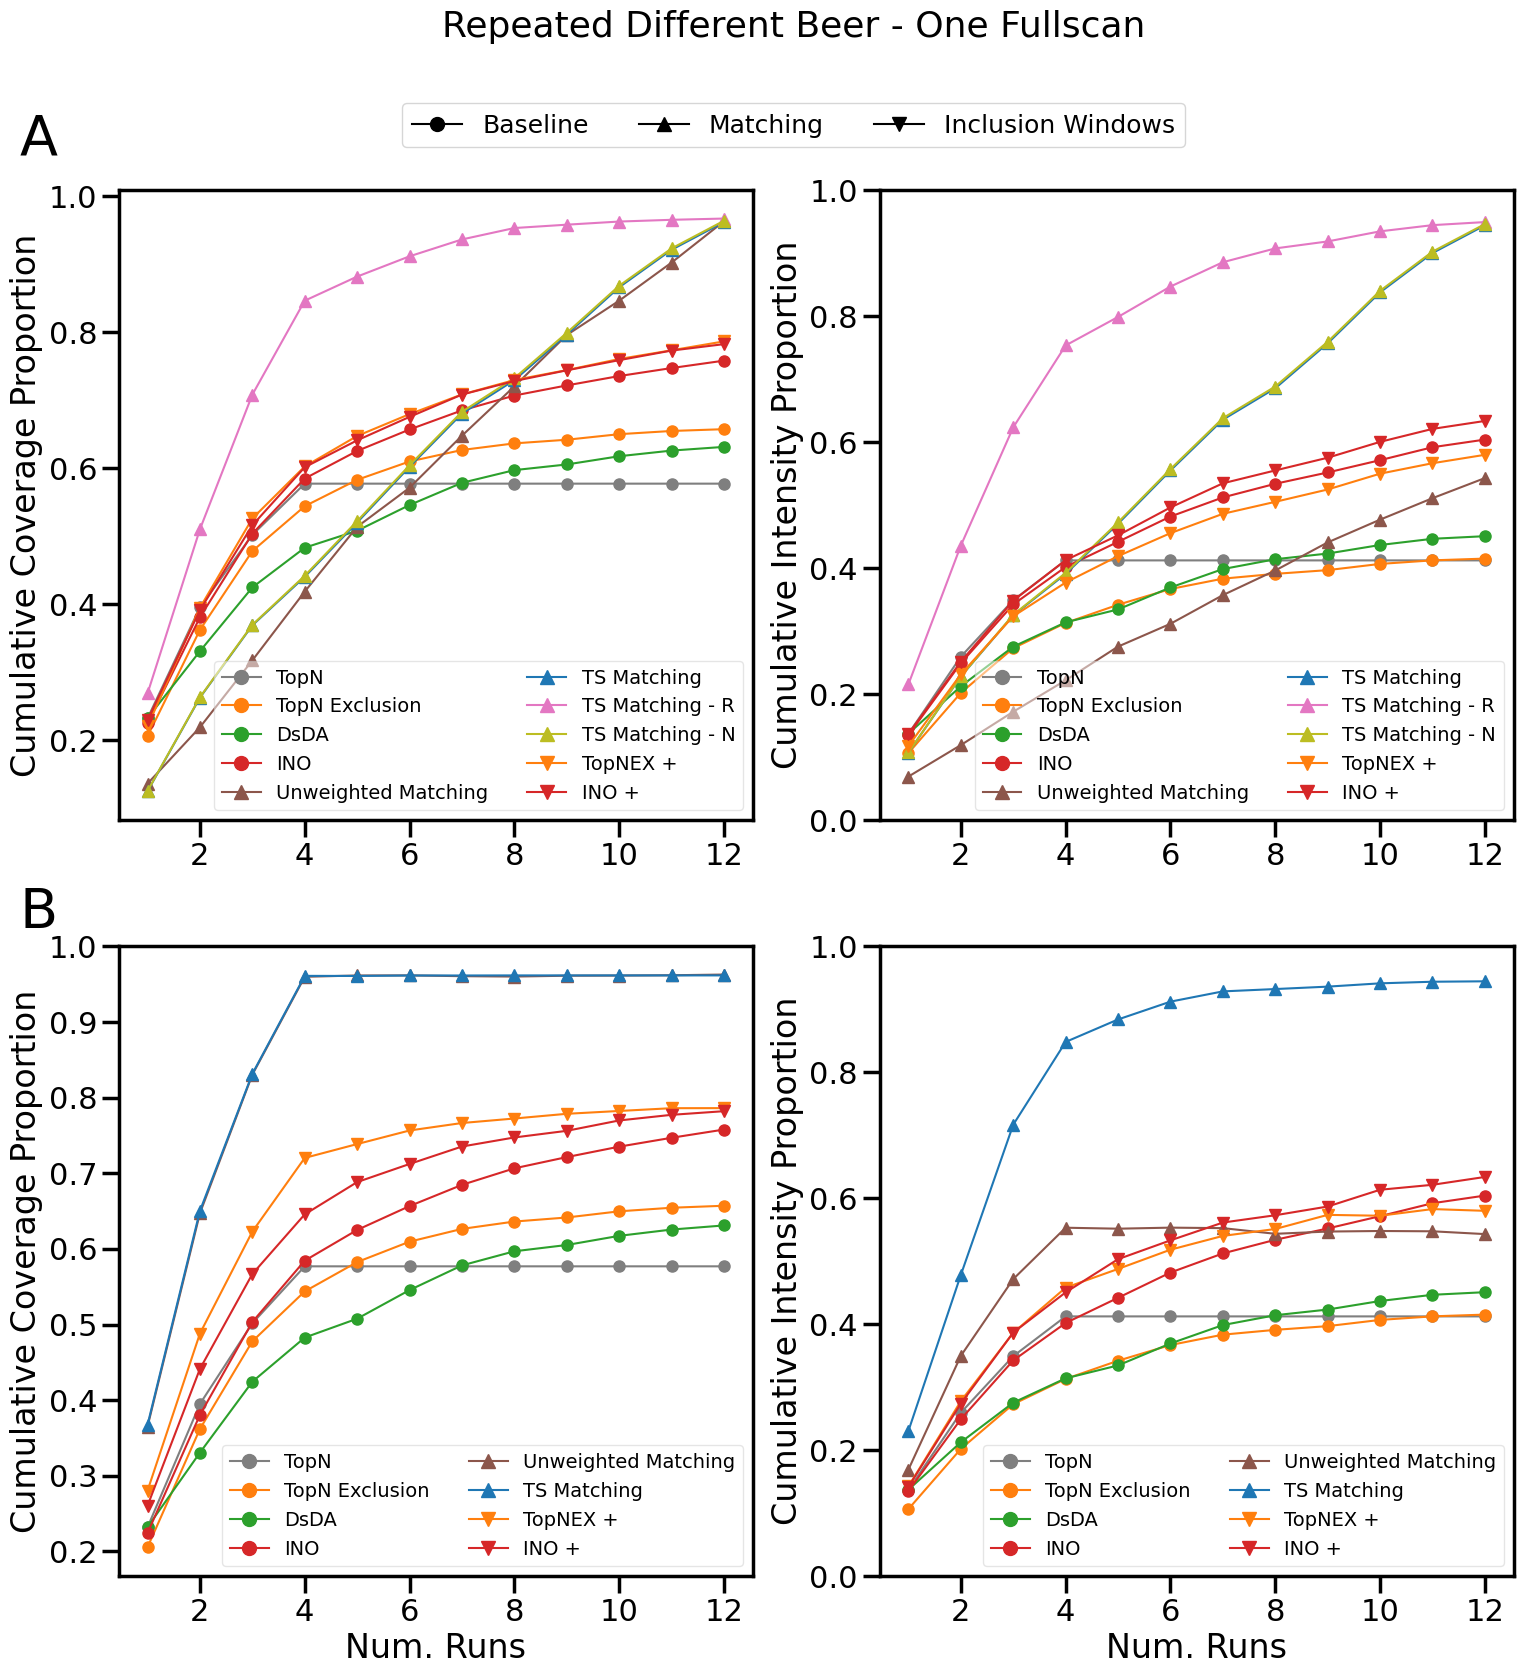

In [31]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Repeated Different Beer - One Fullscan"
}

plot_object = ResultsPlot(rep_diff_case_names, matching_case_names, 5000.0)
plot_object.add_lines(rep_diff_beer_exps[0])
plot_object.output_figure(f"repeated_different_beer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(2, 13, 2)))

# 5+6. Repeating Different Beers (Different Fullscans, Same+Different Plan)

### Evaluate

In [32]:
bio_repeat = 4
tech_repeat = 3
repeat = bio_repeat * tech_repeat
iterbeer_dir = "repeated_different_iterbeer"
iterswapbeer_dir = "repeated_different_iterswapbeer"

rep_diff_case_names = [
    "topN",
    #"topN_RoI",
    "topN_exclusion",
    "dsda",
    #"topNEx",
    #"topNEx_smartroi",
    #"topNEx_weighteddew",
    #"hard_roi_exclusion",
    #"hard_roi_exclusion_smartroi",
    #"hard_roi_exclusion_weighteddew",
    #"intensity_roi_exclusion",
    #"intensity_roi_exclusion_smartroi",
    #"intensity_roi_exclusion_weighteddew",
    #"non_overlap",
    #"non_overlap_smartroi",
    #"non_overlap_weighteddew",
    #"intensity_non_overlap",
    "intensity_non_overlap_smartroi",
    #"intensity_non_overlap_weighteddew",
    "unweighted_matching",
    "two_step_matching",
    "two_step_matching_with_recursive_assignment",
    "two_step_matching_with_nearest_assignment",
    "topNEx_inclusion", 
    "intensity_non_overlap_smartroi_inclusion"
]

line_colours, line_markers = get_line_styles(rep_diff_case_names)
legend_elements = get_legend_items(rep_diff_case_names)
style_dict = {
    case_name : (c, m) 
    for case_name, c, m in zip(rep_diff_case_names, line_colours, line_markers)
} # use to get line styles for a subset

print(style_dict)

matching_case_names = [
    name for name in list(inclusion_dda_name_map.keys()) + list(matching_name_map.keys()) 
    if name in rep_diff_case_names
]
other_case_names = [name for name in rep_diff_case_names if not name in matching_case_names]

{'topN': ('#7f7f7f', 'o'), 'topN_exclusion': ('#ff7f0e', 'o'), 'dsda': ('#2ca02c', 'o'), 'intensity_non_overlap_smartroi': ('#d62728', 'o'), 'unweighted_matching': ('#8c564b', '^'), 'two_step_matching': ('#1f77b4', '^'), 'two_step_matching_with_recursive_assignment': ('#e377c2', '^'), 'two_step_matching_with_nearest_assignment': ('#bcbd22', '^'), 'topNEx_inclusion': ('#ff7f0e', 'v'), 'intensity_non_overlap_smartroi_inclusion': ('#d62728', 'v')}


In [33]:
isolation_width = 1.0
#isolation_width = None

rep_diff_beer_dirs = (iterbeer_dir, iterswapbeer_dir)
rep_diff_beer_exps = [[] for dir in rep_diff_beer_dirs]

for out_dir, exp_list in zip(rep_diff_beer_dirs, rep_diff_beer_exps):
    for i in range(repeat):
        iter_dir = os.path.join(out_dir, str(i+1))
        
        if(os.path.exists(iter_dir)):
        
            iter_exp = Experiment.load_from_json(
                file_dir = iter_dir,
                file_name = "keyfile.json",
                out_dir = iter_dir,
                fullscan_dir = data_dir,
                amend_result_path = True,
                case_names = None
            )
            
            iter_exp.evaluate(
                pp_params = pp_params,
                num_workers = num_workers,
                isolation_widths = isolation_width,
                max_repeat = repeat,
                aligned_names = f"stefanbeersID{id_offset+repeat+1}-{id_offset+2*repeat}" + template_suffix,
                force_peak_picking = False
            )
            
            exp_list.append(iter_exp)

17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file

17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file

17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 aligned boxes contained in file
17741 alig

In [34]:
rep_diff_beer_exps[0][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

two_step_matching_with_recursive_assignment
Number of chems above min intensity: 14970
Number of fragmentations: [6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560, 6560]
Cumulative coverage: [2415, 4665, 6493, 8079, 9263, 10300, 11271, 12152, 12803, 13395, 13908, 14404]
Cumulative coverage proportion: [0.16132264529058116, 0.31162324649298595, 0.43373413493653973, 0.5396793587174349, 0.6187708750835004, 0.6880427521710086, 0.7529058116232465, 0.8117568470273882, 0.855243820975284, 0.8947895791583166, 0.9290581162324649, 0.962191048764195]
Cumulative intensity proportion: [0.11541049845745181, 0.23741021334225343, 0.3377920265141761, 0.4152642002759744, 0.4913329727215592, 0.5715032751662543, 0.641969859086295, 0.6979404006711891, 0.7548461894622353, 0.8158782370843832, 0.8660938169434146, 0.9095235667667765]
Cumulative intensity proportion of covered spectra: [0.7154017233573722, 0.761850137992183, 0.7787997284640715, 0.7694646711389203, 0.7940467021096557, 0.8306217504

In [35]:
rep_diff_beer_exps[1][-1].summarise(num_workers=num_workers, min_intensities=5000.0, rank_key="cumulative_intensity_proportion")

intensity_non_overlap_weighteddew_inclusion
Number of chems above min intensity: 14931
Number of fragmentations: [6558, 6558, 6558, 6558, 6555, 6558, 6558, 6558, 6555, 6558, 6558, 6558]
Cumulative coverage: [2393, 4281, 5730, 6876, 7719, 8408, 8975, 9450, 9856, 10215, 10554, 10847]
Cumulative coverage proportion: [0.16027057799209699, 0.28671890697207153, 0.3837653204741812, 0.4605183845690175, 0.5169780992565802, 0.5631237023642087, 0.6010983859085125, 0.6329113924050633, 0.6601031411157994, 0.6841470765521398, 0.7068515169780992, 0.7264751188801821]
Cumulative intensity proportion: [0.08391561334898961, 0.1639445254885114, 0.2310970837061062, 0.2790712975987044, 0.3248842684675221, 0.36836684035458434, 0.4038911659061521, 0.4306460731439382, 0.45992659859804547, 0.49037486711088424, 0.5157214446185667, 0.5352248571494786]
Cumulative intensity proportion of covered spectra: [0.5235871387019491, 0.571795307187331, 0.6021833432488433, 0.6059938255448307, 0.6284294613924826, 0.6541490596

### Plot

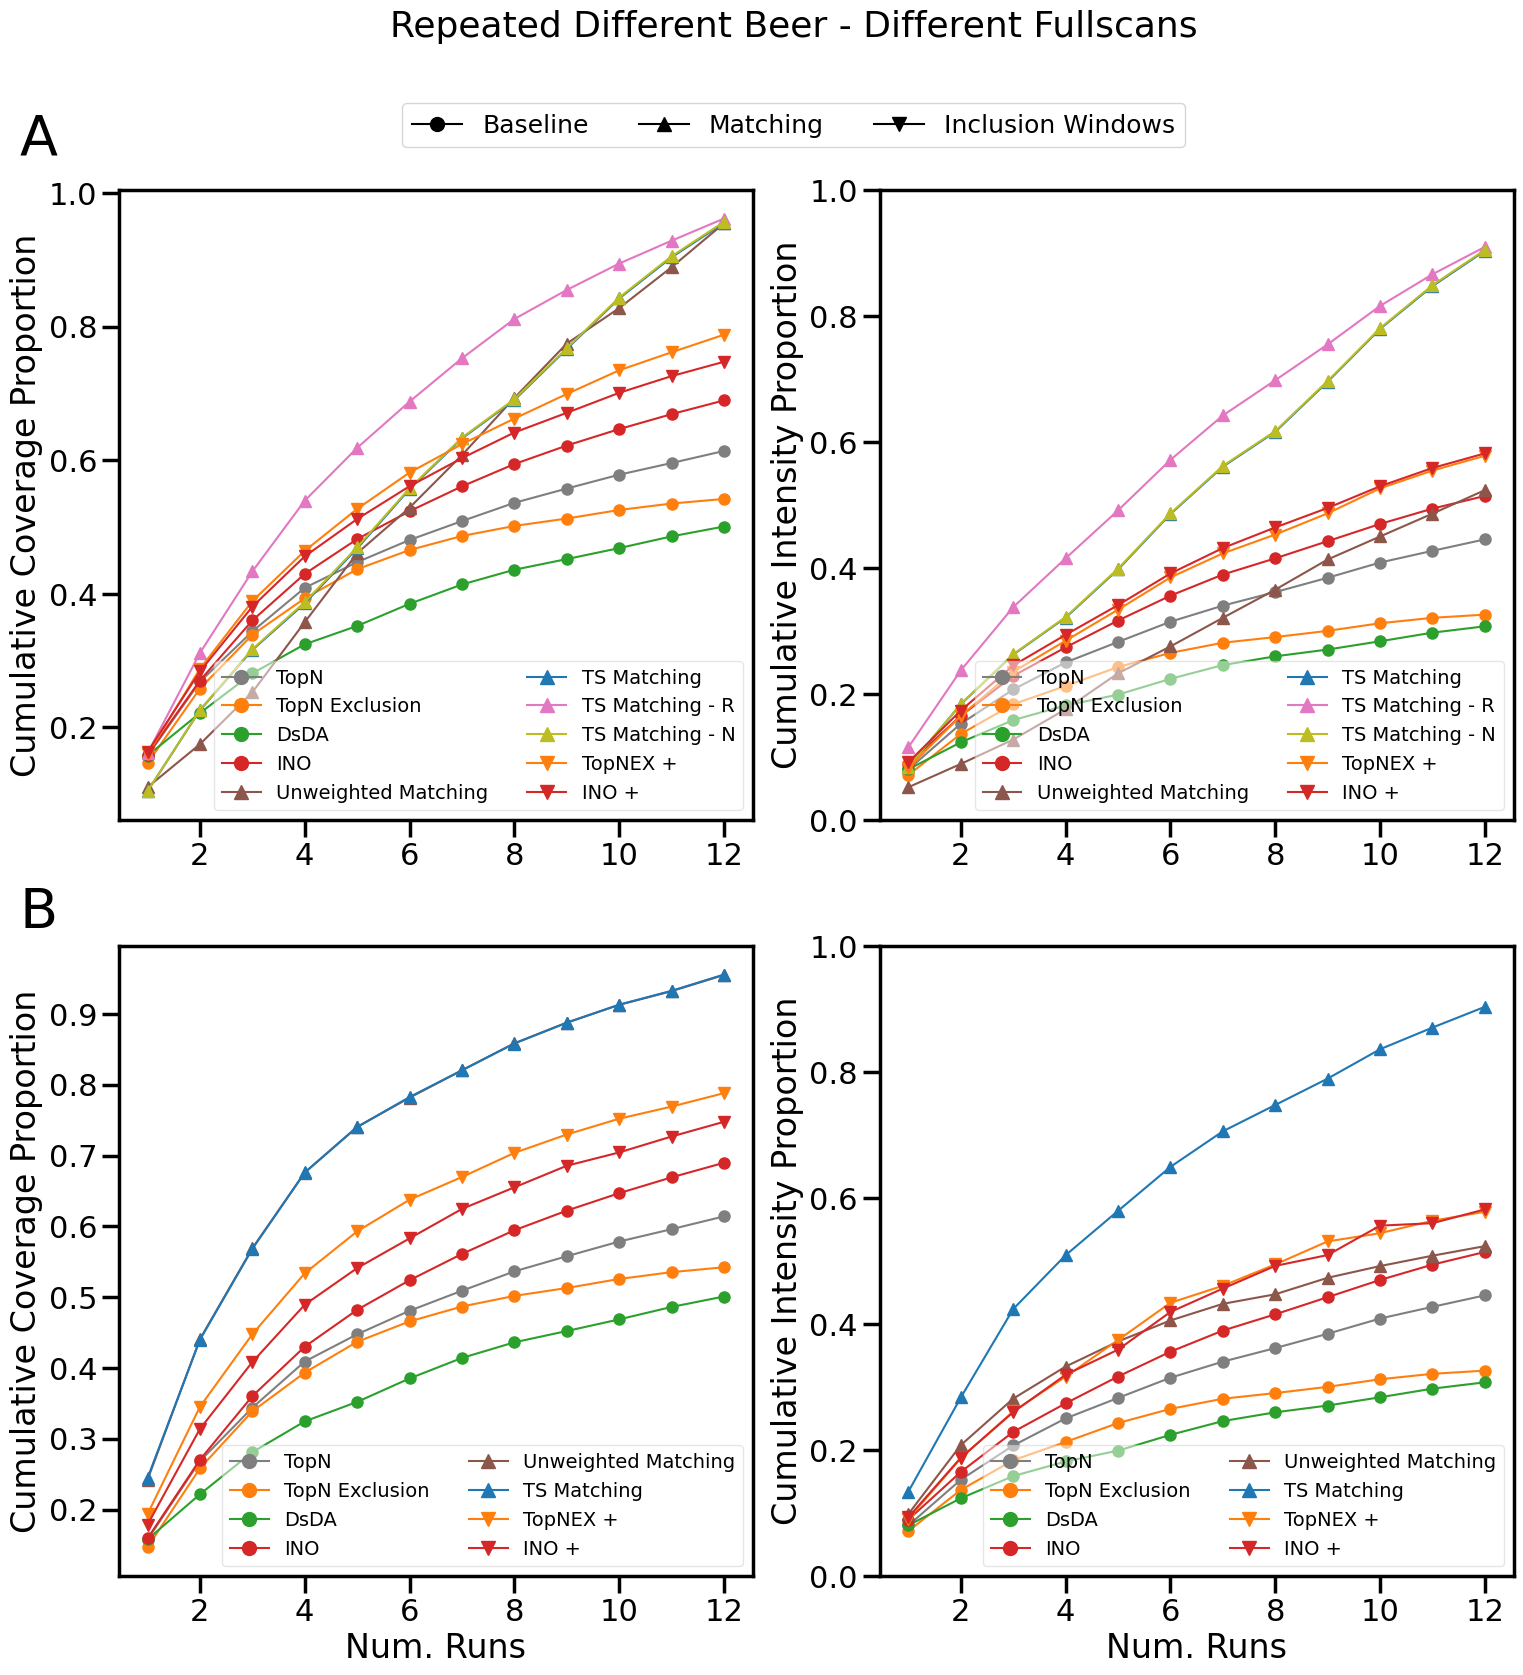

In [36]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Repeated Different Beer - Different Fullscans"
}

plot_object = ResultsPlot(rep_diff_case_names, matching_case_names, 5000.0)
plot_object.add_lines(rep_diff_beer_exps[0])
plot_object.output_figure(f"repeated_different_iterbeer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(2, 13, 2)))

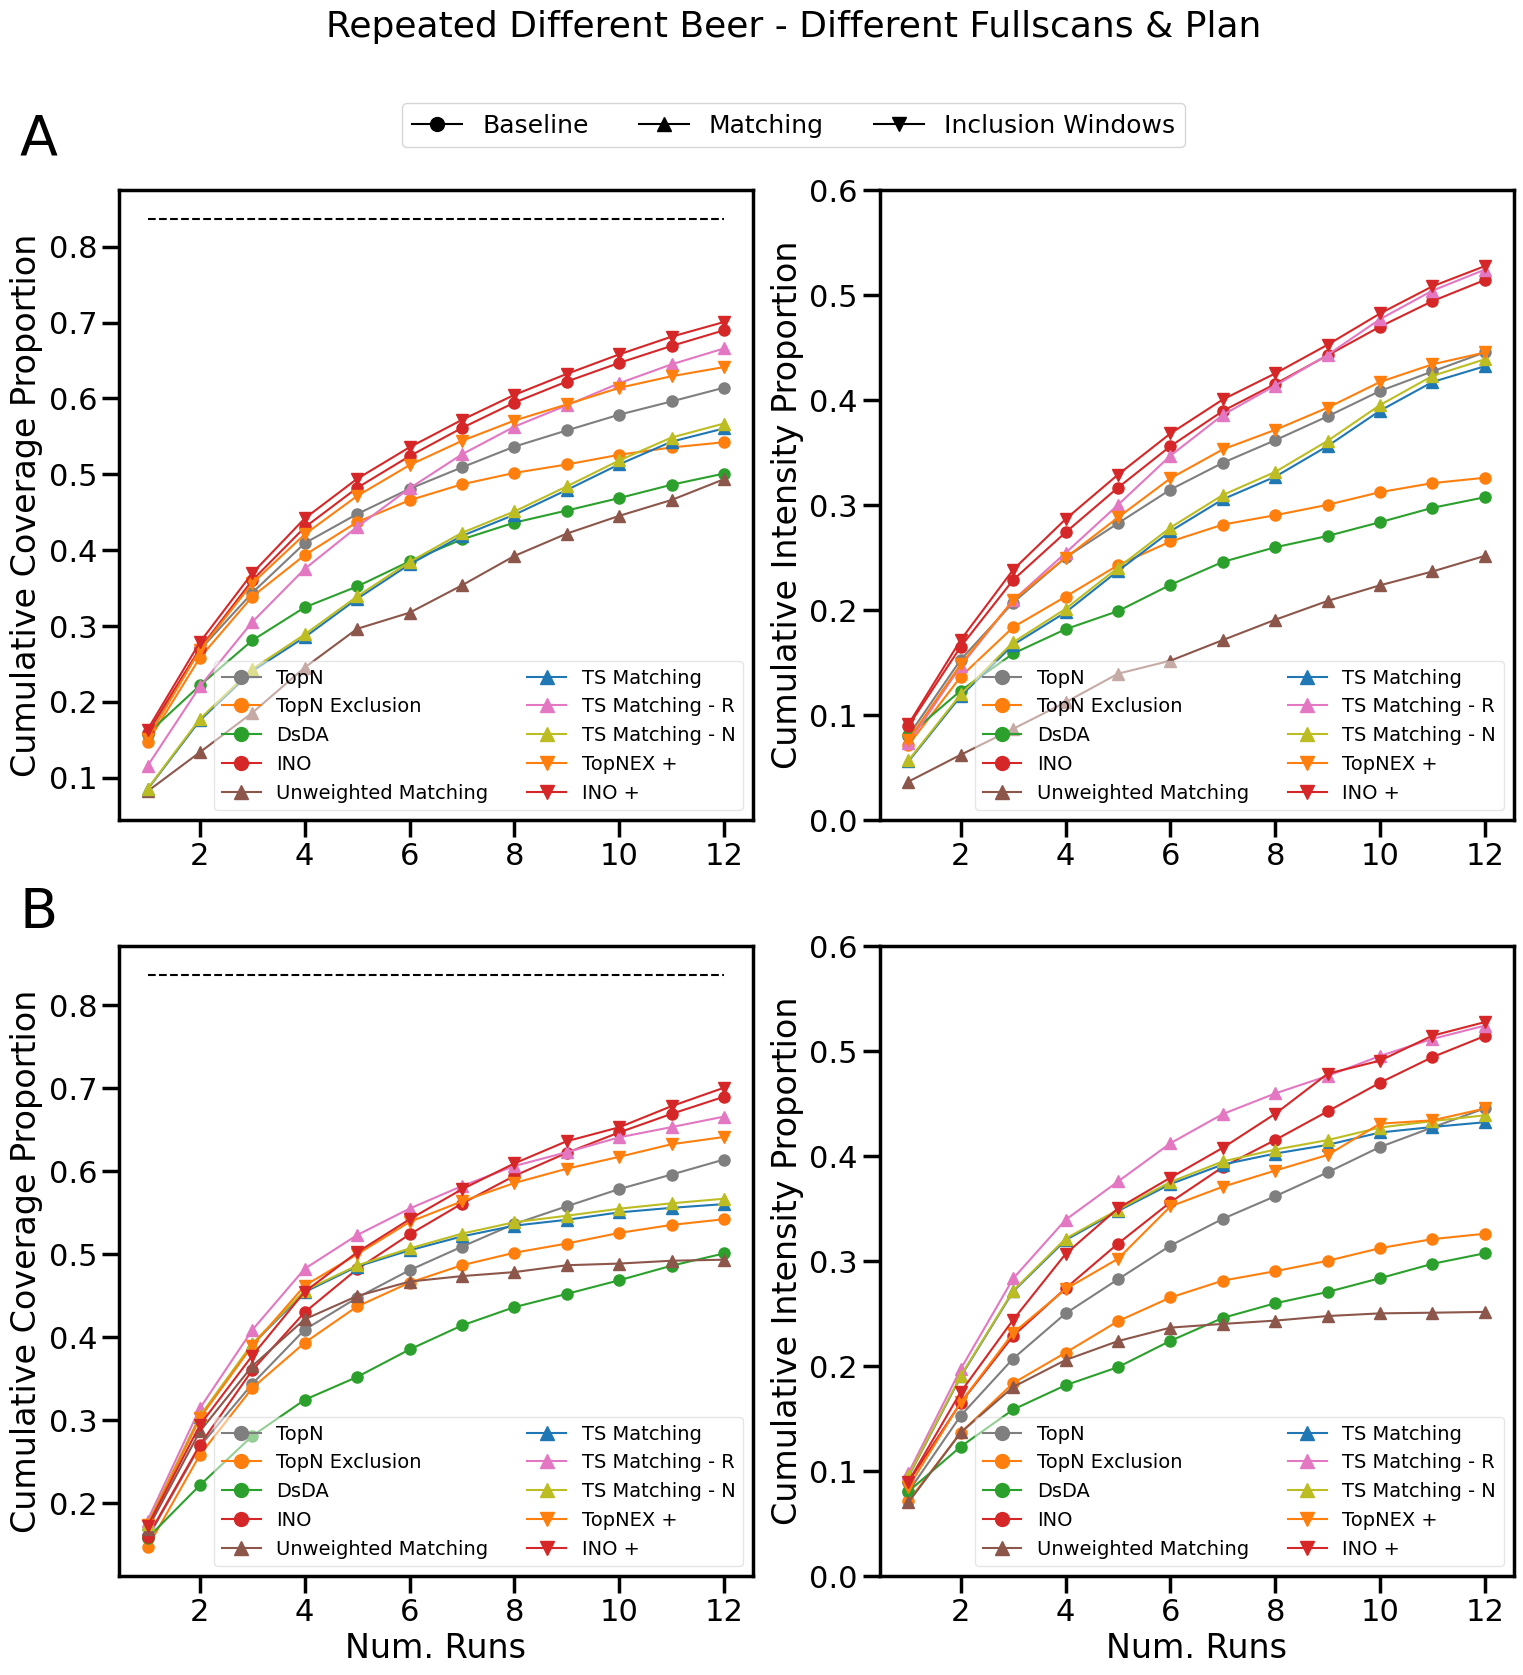

In [37]:
kwargs = {
    **fig_kwargs,
    "suptitle" : "Repeated Different Beer - Different Fullscans & Plan"
}

plot_object = ResultsPlot(rep_diff_case_names, matching_case_names, 5000.0)
#NB: compare sets must be in the order of planning -> real
compare_sets = [
    ["".join(os.path.basename(name).split(".")[:-1]) for name in rep_diff_beer_fullscans[:repeat]],
    ["".join(os.path.basename(name).split(".")[:-1]) for name in rep_diff_beer_fullscans[repeat:repeat*2]]
]
plot_object.count_peak_overlap(pp_params, "repeated_different_iterswapbeer", f"stefanbeersID{id_offset+1}-{id_offset+2*repeat}", compare_sets=compare_sets)
plot_object.add_iterswaplines(rep_diff_beer_exps[0], rep_diff_beer_exps[1])
plot_object.output_figure(f"repeated_different_iterswapbeer_{pp_params.method_name.lower()}{param_suffix}.pdf", fig_kwargs=kwargs, xticks=list(range(2, 13, 2)))